# Lesson: degree day model

Today we are going to use the [degree day model](http://www.antarcticglaciers.org/glaciers-and-climate/numerical-ice-sheet-models/modelling-glacier-melt/) (DDM) as a pretext to learn a little bit more about logical tools in numpy/pandas.


**Spend some time to read the webpage explaining how the simple degree day model works.**

We will use the AWS data at Zhadang, but in a good shape this time (with variable names and corrected time):

    $ /scratch/c707/c7071047/data_ss2016/aws_data_zhadang_localtime.csv

In [22]:
# imports and defaults
import pandas as pd  
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 14
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

In [2]:
# read the data
df = pd.read_csv('aws_data_zhadang_localtime.csv', index_col=0, parse_dates=True)

The DDM works best with daily (or sometimes even monthly) time steps. So we resample:

In [3]:
# resample 
df = df.resample('D').mean()

To test the model, we are concetrating on the melting season 2012, which I define as follows:

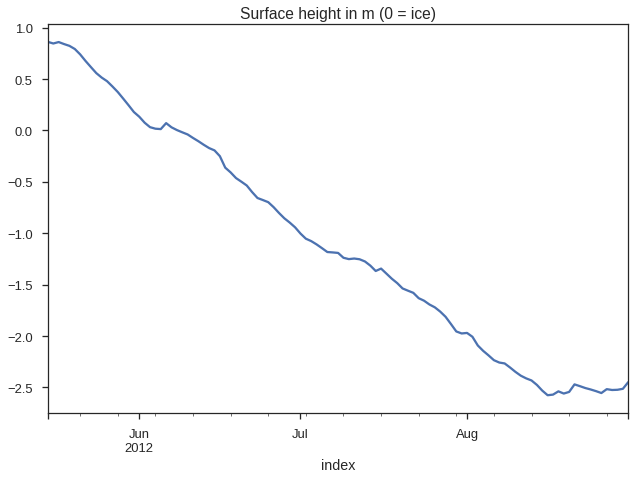

In [4]:
df = df.loc['2012-05-15':]
df['SR50'].plot(title='Surface height in m (0 = ice)');

## 1. Simplest DDM

For the simplest DDM, we are going to use a single factor for the entire melting period. The DDM formulation is very simple:

$$Melt = f \cdot PDD$$

Where PDD is the sum total of daily average temperatures above 0°C in a given time period and f is a melting factor. Let's define the melt in meters of snow/ice which is melted away (remember yesterday's discussion about the standard units of melt?). Determine the unit that $f$ should have in that (quite clumsy) case.

OK, so now we need to count the PDD's over that period. One method that you already learned is following:

In [5]:
# select all days with temp above 0
seltemp = df.TEMP.loc[df.TEMP > 0]
# sum it
seltemp.sum()

251.98720833333334

For the purpose of our modelling, however, it is easier to define a new variable (PDD), which is the daily average of temperature when it is above 0°C, and zero otherwise. For this we are using the numpy function [np.where](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.where.html):

In [6]:
df['PDD'] = np.where(df.TEMP > 0, df.TEMP, 0)

**Q: read the documentation for np.where. Try it out with simple data. Can you understand what it does? Verify that the the sum of this  new PDD variable corresponds to our computation above.**

In [7]:
# your answer here

Now we are going to calibrate our model, i.e. we are computing our factor $f$. The total of snow/ice melt (in m) during this period is:

In [8]:
obs_melt = df.SR50.iloc[-1] - df.SR50.iloc[0]  # what is iloc[] by the why? Ask the notebook!
obs_melt

-3.309333333333333

Which gives us a melt factor:

In [9]:
melt_factor = obs_melt / df['PDD'].sum()
melt_factor

-0.013132941768042788

It is now very easy to define a variable (MELT1), which is the daily melt due to this factor:

In [10]:
df['MELT1'] = df['PDD'] * melt_factor

**E: plot this new variable. What are we looking at?**

In [11]:
# answer here

In order to compare this melt with observations, we should compute its cumulative sum: 

In [12]:
df['MELT1'] = (df['PDD'] * melt_factor).cumsum()

If you plot this variable again, you will see that something is still missing. Therefore, we now add the starting snow depth to this timeserie. We select the first element of the observations array with `iloc[]` and add it to ours:

In [13]:
df['MELT1'] = (df['PDD'] * melt_factor).cumsum() + df.SR50.iloc[0]

Done! Let's plot the result of our modeling approach:

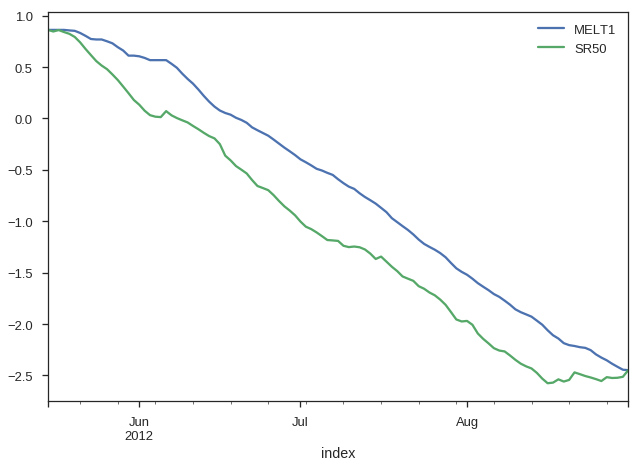

In [14]:
df[['MELT1', 'SR50']].plot();

**Q: discuss the performance of our model. Where is it performing well? Where is it performing less well? Can you tell why?**

## 2. A more reasonable DDM

It is more reasonable to distinguish between snow and ice in our model. Fortunately, the person whe provided the data nicely set the 0 level to the original ice surface before the ablation season.

**E: add a new variable IS_SNOW to the dataframe, which is equal to True when the surface is above 0 and to False otherwise.**

In [15]:
# your answer here

In [16]:
df['IS_SNOW'] = np.where(df.SR50 > 0, True, False)

We are now computing the melt factor for the snowmelt period:

In [17]:
# first, compute the PDD sum during the snowmelt period:
pdd_snow = df.PDD.loc[df['IS_SNOW']].sum()
# Then, compute the observed melt during this period. It is simply:
melt_snow = - df.SR50.iloc[0]
# Finally, compute the factor:
fac_snow = melt_snow / pdd_snow

For the ice surface, we have to introduce a new operator, "~". This is the logical operator for "not":

In [18]:
print(~ np.array([True, False, True]))

[False  True False]


Once we have this, computing the PDD sum during the ice period is easy:

In [19]:
# first, compute the PDD sum during the ice melt period:
pdd_ice = df.PDD.loc[~ df['IS_SNOW']].sum()  # note the ~
# Then, compute the observed melt during this period. It is simply:
melt_ice = df.SR50.iloc[-1]
# Finally, compute the factor:
fac_ice = melt_ice / pdd_ice

**Q: compare the two factors. Discuss their relative value in light of the physical properties of snow and ice. Does it make sense for you?**

**E: define a new variable (MIXED_FAC) in the dataframe, which is equal to fac_snow during the snow period and to fac_ice otherwise. Using the same approach as before, compute a new variable MELT2 wich is the sumulative melt during that period. Plot it together with the SR50 observations.**

In [20]:
# your answer here

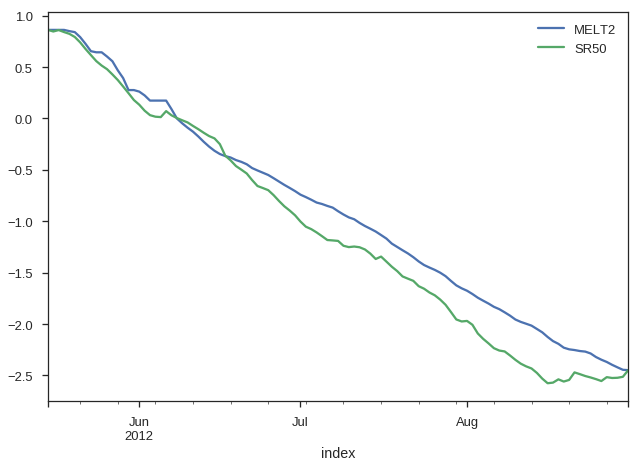

In [21]:
df['MIXED_FAC'] = np.where(df['IS_SNOW'], fac_snow, fac_ice)
df['MELT2'] = (df['PDD'] * df['MIXED_FAC']).cumsum() + df.SR50.iloc[0]
df[['MELT2', 'SR50']].plot();

**Q: discuss the performance of our new model. Is it performing better than before? Can you tell why?**

## 3. A even more reasonable DDM

In our previous models, we compeletely neglected snowfall, which of course is bad. If you are ambitious, you can try to propose solutions to this problem.

Now you can continue with exercise 05 (on OLAT or on the scratch directory, as usual).